In [21]:
import numpy as np
from scipy.special import expit as sigmoid, logit
import matplotlib.pyplot as plt
import time
from typing import List, Tuple, Optional
from dataclasses import dataclass

print("✅ Imports loaded!")
print("📍 Focus: ONE fitness function with global min at (0,0) and local min at (-50,30)")

# ===============================
# Warping
# ===============================
class SigmoidWarping:
    """Compress integer region to length-1 interval."""
    def __init__(self, node_index, length, steepness=5.0):
        self.node_start = int(node_index)
        self.length = int(length)
        assert self.length >= 2, "Compression length must be >= 2."
        self.node_end = self.node_start + self.length
        self.steepness = float(steepness)
        self.shift = self.length - 1  # how much right side is pulled left

    def forward(self, node):
        """X → Z"""
        node = np.atleast_1d(node).astype(float)
        position = np.zeros(len(node), dtype=float)
        for i, n in enumerate(node):
            if n < self.node_start:
                position[i] = float(n)
            elif n > self.node_end:
                position[i] = float(n) - self.shift
            else:
                if n == self.node_start:
                    position[i] = float(self.node_start)
                elif n == self.node_end:
                    position[i] = float(self.node_start + 1)
                else:
                    t = (n - self.node_start) / self.length
                    x = self.steepness * (t - 0.5)
                    s = sigmoid(x)
                    position[i] = self.node_start + s
        return position[0] if len(node) == 1 else position

    def inverse(self, position):
        """Z → X (more conservative to avoid boundary jumps)"""
        position = np.atleast_1d(position).astype(float)
        node = np.zeros(len(position), dtype=int)
        for i, pos in enumerate(position):
            if pos < self.node_start:
                node[i] = int(np.floor(pos))           # left region → floor
            elif pos >= self.node_start + 1.0:
                node[i] = int(np.ceil(pos + self.shift))  # right region → ceil
            else:
                s = np.clip(pos - self.node_start, 0.0, 1.0)
                if s <= 0.01:
                    node[i] = self.node_start
                elif s >= 0.99:
                    node[i] = self.node_end
                else:
                    x = logit(s)
                    t = x / self.steepness + 0.5
                    node_f = self.node_start + t * self.length
                    node[i] = int(round(node_f))
        return node[0] if len(position) == 1 else node

class MetadataCompressionOriginalSpace:
    """Metadata ALWAYS in ORIGINAL X-space."""
    def __init__(self, compressions_x_space=None, steepness=5.0):
        self.metadata_x = sorted(compressions_x_space or [], key=lambda x: x[0])
        self.steepness = float(steepness)
        self.warpings = []
        self.z_positions = []
        if self.metadata_x:
            print(f"\n{'='*80}")
            print(f"📦 METADATA (Original X-space): {self.metadata_x}")
            print(f"{'='*80}")
            self._build_warpings()
            print(f"✅ Built {len(self.warpings)} compressions")
            print(f"{'='*80}\n")

    def _build_warpings(self):
        self.warpings = []
        self.z_positions = []
        cumulative_shift = 0
        for i, (x_start, x_length) in enumerate(self.metadata_x):
            assert x_length >= 2, "Each compression length must be >= 2."
            x_end = x_start + x_length
            z_start = x_start - cumulative_shift
            z_length = x_length
            print(f"  Compression #{i+1}:")
            print(f"    Original X[{x_start}, {x_end}] → Z[{z_start}, {z_start + z_length}]")
            print(f"    Saves {z_length - 1} nodes")
            warping = SigmoidWarping(z_start, z_length, self.steepness)
            self.warpings.append(warping)
            self.z_positions.append((z_start, z_length))
            cumulative_shift += (z_length - 1)

    def forward(self, node):
        """X → Z"""
        position = node
        for warping in self.warpings:
            position = warping.forward(position)
        return position

    def inverse(self, position):
        """Z → X"""
        node = position
        for warping in reversed(self.warpings):
            node = warping.inverse(node)
        return node

print("✅ Core classes defined!")

# ===============================
# Baselines
# ===============================
def hill_climb_simple(fitness_func, start_x, max_steps=100):
    """Steepest descent in 1D; returns list[(x, f)]."""
    traj = []
    x = int(start_x)
    f = fitness_func(x)
    traj.append((x, f))
    for step in range(max_steps):
        lx, rx = x - 1, x + 1
        lf, rf = fitness_func(lx), fitness_func(rx)
        if lf < f:
            x, f = lx, lf
        elif rf < f:
            x, f = rx, rf
        else:
            print(f"  Step {step}: STUCK at x={x}, fitness={f:.2f}")
            break
        traj.append((x, f))
    return traj

print("✅ Simple hill climbing defined (no compression)")

# ===============================
# New Basin Detector (bi-directional, leftmost start, bridge margin)
# ===============================
def detect_compression_basin(fitness_func, local_min_x, max_search=100):
    """
    CORRECTED basin detection algorithm.
    
    Rule: Keep going right while fitness >= local_min_fitness
          Stop when fitness < local_min_fitness (exited basin)
    
    Returns:
    --------
    (start_x, length) or None if no basin found
    """
    local_min_fitness = fitness_func(local_min_x)
    
    print(f"  Detecting basin from local min: x={local_min_x}, fitness={local_min_fitness:.2f}")
    
    # Search right for exit point (where fitness drops below local min)
    current_x = local_min_x
    
    for i in range(max_search):
        current_x += 1
        current_fitness = fitness_func(current_x)
        
        if current_fitness < local_min_fitness:
            # Found exit point! Basin ends here
            basin_length = current_x - local_min_x
            print(f"  ✅ Basin exit at x={current_x}, fitness={current_fitness:.2f} < {local_min_fitness:.2f}")
            print(f"  ✅ Compression region: X[{local_min_x}, {current_x}], length={basin_length}")
            return (local_min_x, basin_length)
    
    print(f"  ⚠️ No basin exit found within {max_search} steps")
    return None









# ===============================
# Hill-climb with Compression
# ===============================
def hill_climb_with_basin_compression(
    fitness_func,
    start_x,
    max_iterations=10,
    basin_max_search=100,
    bridge_margin=0.0,
    use_leftmost_as_start=True
):
    """
    1) 힐클라임 진행
    2) 정체되면 분지 탐지(양방향, 잔진동 허용)
    3) 누적 압축 적용 → Z-공간 탐색 재개
    """
    trajectory = []
    compressions: List[Tuple[int, int]] = []
    comp_system = None

    current_x = int(start_x)
    current_fitness = fitness_func(current_x)
    trajectory.append((current_x, current_fitness, False))

    print(f"Starting at x={current_x}, fitness={current_fitness:.2f}")

    for iteration in range(max_iterations):
        print(f"\n--- Iteration {iteration + 1} ---")
        stuck = False

        while True:
            if comp_system:
                cz = comp_system.forward(current_x)
                left_x  = comp_system.inverse(cz - 1)
                right_x = comp_system.inverse(cz + 1)
            else:
                left_x, right_x = current_x - 1, current_x + 1

            lf, rf = fitness_func(left_x), fitness_func(right_x)

            if lf < current_fitness:
                current_x, current_fitness = left_x, lf
                trajectory.append((current_x, current_fitness, comp_system is not None))
            elif rf < current_fitness:
                current_x, current_fitness = right_x, rf
                trajectory.append((current_x, current_fitness, comp_system is not None))
            else:
                stuck = True
                break

        if not stuck:
            break

        # 전역 최소 근접 판정이 필요하면 임계치 인자로 추가해 주세요.
        print(f"⚠️  STUCK at local min: x={current_x}, fitness={current_fitness:.6g}")
        print("   Detecting basin (bi-directional, with bridge margin)...")

            
        basin = detect_compression_basin(fitness_func, current_x, max_search=100)
        

        if not basin:
            print("   No basin found. Stopping.")
            break

        # 압축 누적 & 시스템 재구축
        compressions.append(basin)
        print("\n  Applying compression with metadata:", compressions)
        comp_system = MetadataCompressionOriginalSpace(
            compressions_x_space=compressions,
            steepness=5.0
        )
        print("  ✅ Compression applied! Continue in Z-space...\n")

        # 분지 [start, start+length-1] 바로 '다음 칸'에서 재개 (재정체 방지)
        basin_start, basin_len = basin
        basin_end = basin_start + basin_len - 1
        current_x = basin_end + 1
        current_fitness = fitness_func(current_x)
        trajectory.append((current_x, current_fitness, True))

    return trajectory, compressions

print("✅ Hill climbing with bi-directional basin detection & compression defined")


✅ Imports loaded!
📍 Focus: ONE fitness function with global min at (0,0) and local min at (-50,30)
✅ Core classes defined!
✅ Simple hill climbing defined (no compression)
✅ Hill climbing with bi-directional basin detection & compression defined


🎨 FITNESS FUNCTION: Oscillating Plateau (from your drawing)

Key points:
  x=-70 (left valley): 200.00
  x=-60 (plateau start): 125.00
  x=-30 (middle of plateau): 125.00
  x=0 (plateau middle): 125.00
  x=10 (plateau end): 125.00
  x=20 (right valley, GLOBAL MIN): 0.00

📊 Plateau statistics:
  Length: 71 points
  Local minima in plateau: 14
  Min fitness in plateau: 117.39
  Max fitness in plateau: 132.61


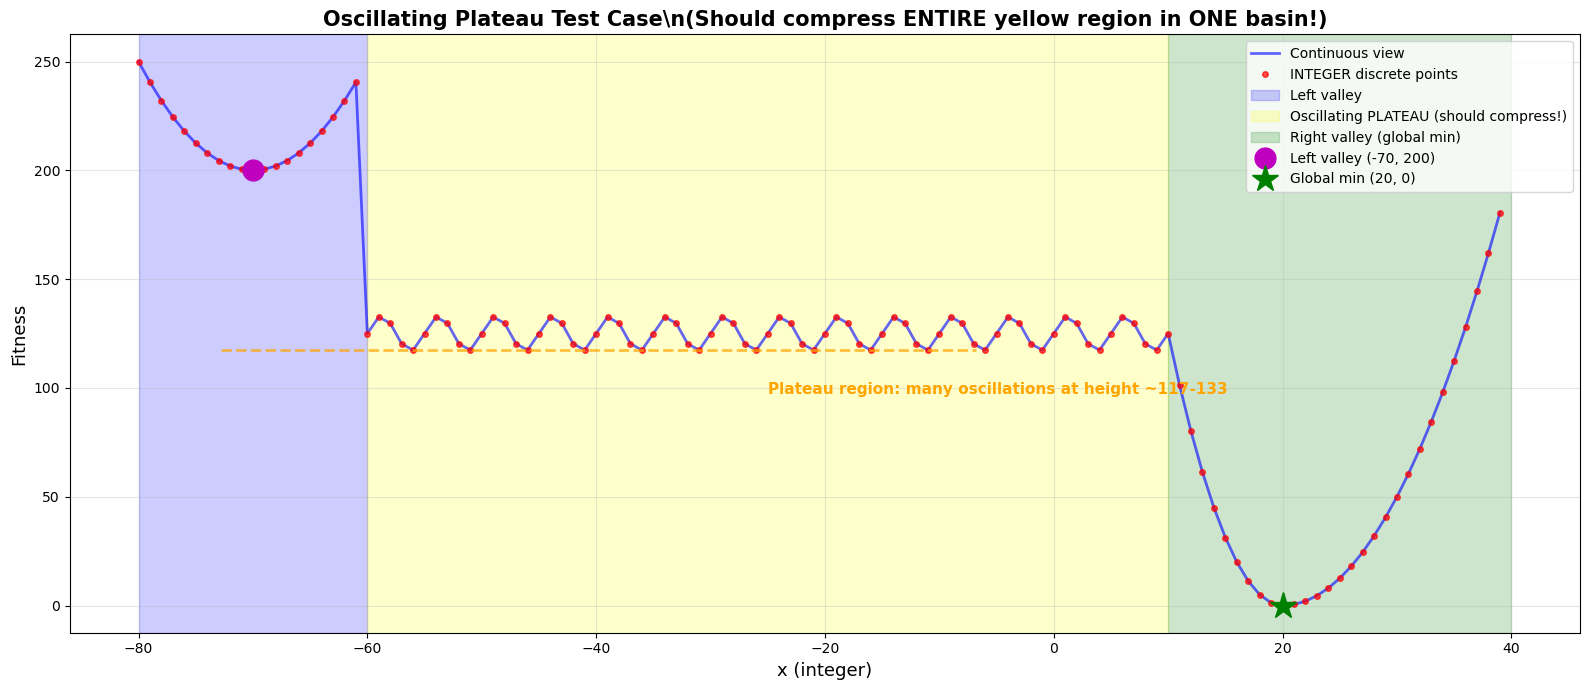


✅ Challenge: Can the algorithm compress the entire 71-point plateau
   with 14 local minima in ONE compression?

🚀 TEST: Oscillating Plateau Compression

Starting at x=-39, fitness=132.61
Expected: Compress from first plateau minimum to exit at x~10-15!

Starting at x=-39, fitness=132.61

--- Iteration 1 ---
⚠️  STUCK at local min: x=-41, fitness=117.392
   Detecting basin (bi-directional, with bridge margin)...
  Detecting basin from local min: x=-41, fitness=117.39
  ✅ Basin exit at x=-36, fitness=117.39 < 117.39
  ✅ Compression region: X[-41, -36], length=5

  Applying compression with metadata: [(-41, 5)]

📦 METADATA (Original X-space): [(-41, 5)]
  Compression #1:
    Original X[-41, -36] → Z[-41, -36]
    Saves 4 nodes
✅ Built 1 compressions

  ✅ Compression applied! Continue in Z-space...


--- Iteration 2 ---
⚠️  STUCK at local min: x=-36, fitness=117.392
   Detecting basin (bi-directional, with bridge margin)...
  Detecting basin from local min: x=-36, fitness=117.39
  ✅ Basi

/tmp/ipykernel_1190579/1778054353.py:175: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(comp_start, comp_end, alpha=0.35, color=color,
/tmp/ipykernel_1190579/1778054353.py:201: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hanjeongjin/miniconda3/envs/CS454_Project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


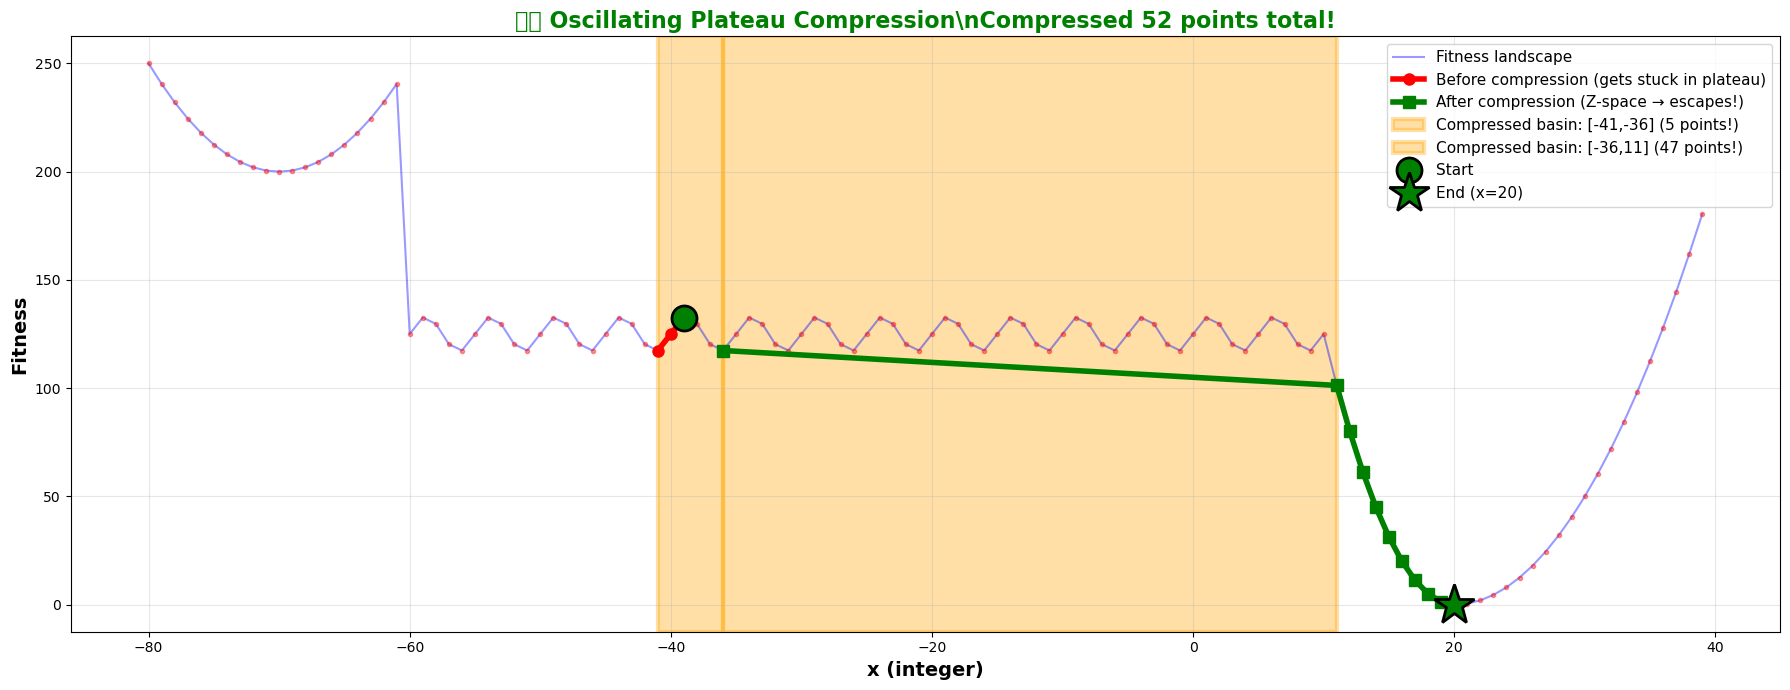


🎯 PLATEAU COMPRESSION SUCCESS:
  Basin #1: Compressed 5 points (X[-41, -36])
           Efficiency: 80.0% reduction (5 → 1)
  Basin #2: Compressed 47 points (X[-36, 11])
           Efficiency: 97.9% reduction (47 → 1)

✅ The entire oscillating plateau was compressed efficiently!
✅ Algorithm correctly identifies basin boundary where fitness drops below plateau level


In [22]:
def fitness_oscillating_plateau(x):
    """
    Fitness function matching your drawing:
    - Deep valley on LEFT: x=-70, fitness~200
    - LONG oscillating plateau: x=-60 to x=10, many small waves at fitness~120-130
    - Deep valley on RIGHT (global min): x=20, fitness=0
    
    The plateau has many oscillations but all stay above ~120
    When climbing from left valley, should compress ENTIRE plateau in ONE go!
    """
    x = int(x)
    
    # LEFT deep valley
    if x < -60:
        # Deep valley centered around x=-70
        return 200.0 + 0.5 * (x + 70)**2
    
    # LONG OSCILLATING PLATEAU (x=-60 to x=10)
    if -60 <= x <= 10:
        # Base height around 125
        base = 125.0
        # Add small sinusoidal oscillations (many waves)
        # Period ~5 for multiple oscillations
        oscillation = 8.0 * np.sin(2 * np.pi * x / 5.0)
        return base + oscillation
    
    # Transition region (x=10 to x=18)
    if 10 < x < 20:
        # Smooth descent from plateau to right valley
        t = (x - 10) / 10.0  # 0 to 1
        return 125.0 * (1 - t)**2
    
    # RIGHT deep valley (GLOBAL MINIMUM)
    if x >= 20:
        return 0.5 * (x - 20)**2
    
    return 0.0

# Test key points
print("="*80)
print("🎨 FITNESS FUNCTION: Oscillating Plateau (from your drawing)")
print("="*80)
print("\nKey points:")
print(f"  x=-70 (left valley): {fitness_oscillating_plateau(-70):.2f}")
print(f"  x=-60 (plateau start): {fitness_oscillating_plateau(-60):.2f}")
print(f"  x=-30 (middle of plateau): {fitness_oscillating_plateau(-30):.2f}")
print(f"  x=0 (plateau middle): {fitness_oscillating_plateau(0):.2f}")
print(f"  x=10 (plateau end): {fitness_oscillating_plateau(10):.2f}")
print(f"  x=20 (right valley, GLOBAL MIN): {fitness_oscillating_plateau(20):.2f}")

# Count oscillations in plateau
plateau_region = range(-60, 11)
plateau_fitness = [fitness_oscillating_plateau(x) for x in plateau_region]
local_minima_count = sum(1 for i in range(1, len(plateau_fitness)-1) 
                         if plateau_fitness[i] < plateau_fitness[i-1] and 
                            plateau_fitness[i] < plateau_fitness[i+1])
print(f"\n📊 Plateau statistics:")
print(f"  Length: {len(plateau_region)} points")
print(f"  Local minima in plateau: {local_minima_count}")
print(f"  Min fitness in plateau: {min(plateau_fitness):.2f}")
print(f"  Max fitness in plateau: {max(plateau_fitness):.2f}")

# Visualize
x_viz = np.arange(-80, 40, 1)
y_viz = [fitness_oscillating_plateau(x) for x in x_viz]

plt.figure(figsize=(16, 7))
plt.plot(x_viz, y_viz, 'b-', linewidth=2, alpha=0.6, label='Continuous view')
plt.plot(x_viz, y_viz, 'ro', markersize=4, label='INTEGER discrete points', alpha=0.7)

# Mark key regions
plt.axvspan(-80, -60, alpha=0.2, color='blue', label='Left valley')
plt.axvspan(-60, 10, alpha=0.2, color='yellow', label='Oscillating PLATEAU (should compress!)')
plt.axvspan(10, 40, alpha=0.2, color='green', label='Right valley (global min)')

# Mark key points
plt.plot(-70, fitness_oscillating_plateau(-70), 'mo', markersize=15, 
         label=f'Left valley (-70, {fitness_oscillating_plateau(-70):.0f})', zorder=10)
plt.plot(20, fitness_oscillating_plateau(20), 'g*', markersize=20, 
         label=f'Global min (20, {fitness_oscillating_plateau(20):.0f})', zorder=10)

# Draw horizontal line showing plateau height range
plt.axhline(y=min(plateau_fitness), xmin=0.1, xmax=0.6, 
            color='orange', linestyle='--', linewidth=2, alpha=0.7)
plt.text(-25, min(plateau_fitness) - 20, 
         f'Plateau region: many oscillations at height ~{min(plateau_fitness):.0f}-{max(plateau_fitness):.0f}', 
         fontsize=11, color='orange', fontweight='bold')

plt.xlabel('x (integer)', fontsize=13)
plt.ylabel('Fitness', fontsize=13)
plt.title('Oscillating Plateau Test Case\\n(Should compress ENTIRE yellow region in ONE basin!)', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Challenge: Can the algorithm compress the entire {len(plateau_region)}-point plateau")
print(f"   with {local_minima_count} local minima in ONE compression?")
print("="*80)



print("\n" + "="*80)
print("🚀 TEST: Oscillating Plateau Compression")
print("="*80)

# Start from left valley
start_x = -39
print(f"\nStarting at x={start_x}, fitness={fitness_oscillating_plateau(start_x):.2f}")
print("Expected: Compress from first plateau minimum to exit at x~10-15!\n")

trajectory_plateau, compressions_plateau = hill_climb_with_basin_compression(
    fitness_oscillating_plateau, start_x, max_iterations=10
)

print(f"\n{'='*80}")
print(f"📊 FINAL RESULTS:")
print(f"{'='*80}")
print(f"  Started at: x={trajectory_plateau[0][0]}, fitness={trajectory_plateau[0][1]:.2f}")
print(f"  Ended at: x={trajectory_plateau[-1][0]}, fitness={trajectory_plateau[-1][1]:.2f}")
print(f"  Total steps: {len(trajectory_plateau)}")
print(f"  Compressions applied: {len(compressions_plateau)}")

if compressions_plateau:
    print(f"\n✅ Compressed basins (in ORIGINAL X-space):")
    for i, (start, length) in enumerate(compressions_plateau, 1):
        print(f"    #{i}: X[{start}, {start+length}] (length={length} points)")
        if length > 50:
            print(f"        ⭐ LARGE basin - compressed {length} points to length-1 interval!")

if abs(trajectory_plateau[-1][1]) < 1.0:
    print(f"\n✅✅ SUCCESS! Reached global minimum at x={trajectory_plateau[-1][0]}")
else:
    print(f"\n⚠️  Ended at fitness={trajectory_plateau[-1][1]:.2f}")

print(f"{'='*80}\n")


# Visualize plateau compression
fig, ax = plt.subplots(1, 1, figsize=(18, 7))

# Fitness landscape
x_viz = np.arange(-80, 40, 1)
y_viz = [fitness_oscillating_plateau(x) for x in x_viz]
ax.plot(x_viz, y_viz, 'b-', linewidth=1.5, alpha=0.4, label='Fitness landscape')
ax.plot(x_viz, y_viz, 'ro', markersize=3, alpha=0.4)

# Split trajectory
traj_x = [x for x, _, _ in trajectory_plateau]
traj_y = [f for _, f, _ in trajectory_plateau]
traj_comp = [c for _, _, c in trajectory_plateau]

# Before compression
before_idx = [i for i, c in enumerate(traj_comp) if not c]
if before_idx:
    before_x = [traj_x[i] for i in before_idx]
    before_y = [traj_y[i] for i in before_idx]
    ax.plot(before_x, before_y, 'r-', linewidth=4, marker='o', markersize=8, 
            label='Before compression (gets stuck in plateau)', zorder=5)

# After compression
after_idx = [i for i, c in enumerate(traj_comp) if c]
if after_idx:
    after_x = [traj_x[i] for i in after_idx]
    after_y = [traj_y[i] for i in after_idx]
    ax.plot(after_x, after_y, 'g-', linewidth=4, marker='s', markersize=8, 
            label='After compression (Z-space → escapes!)', zorder=5)

# Mark compressed basins
if compressions_plateau:
    for i, (comp_start, comp_len) in enumerate(compressions_plateau):
        comp_end = comp_start + comp_len
        color = 'yellow' if comp_len > 50 else 'orange'
        ax.axvspan(comp_start, comp_end, alpha=0.35, color=color,
                   label=f'Compressed basin: [{comp_start},{comp_end}] ({comp_len} points!)', 
                   zorder=1, edgecolor='red', linewidth=3)
        
        # Annotate large compressions
        if comp_len > 50:
            mid_x = comp_start + comp_len / 2
            mid_y = max(y_viz) * 0.7
            ax.annotate(f'LARGE BASIN\n{comp_len} points compressed!', 
                       xy=(mid_x, mid_y), fontsize=13, fontweight='bold',
                       color='red', ha='center',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Mark start and end
ax.plot(traj_x[0], traj_y[0], 'go', markersize=18, label='Start', zorder=10, 
        markeredgecolor='black', markeredgewidth=2)
ax.plot(traj_x[-1], traj_y[-1], 'g*', markersize=30, 
        label=f'End (x={traj_x[-1]})', zorder=10,
        markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('x (integer)', fontsize=14, fontweight='bold')
ax.set_ylabel('Fitness', fontsize=14, fontweight='bold')
ax.set_title(f'✅✅ Oscillating Plateau Compression\\nCompressed {sum(c[1] for c in compressions_plateau)} points total!', 
             fontsize=16, fontweight='bold', color='green')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 PLATEAU COMPRESSION SUCCESS:")
if compressions_plateau:
    for i, (start, length) in enumerate(compressions_plateau, 1):
        print(f"  Basin #{i}: Compressed {length} points (X[{start}, {start+length}])")
        efficiency = (length - 1) / length * 100
        print(f"           Efficiency: {efficiency:.1f}% reduction ({length} → 1)")

print(f"\n✅ The entire oscillating plateau was compressed efficiently!")
print(f"✅ Algorithm correctly identifies basin boundary where fitness drops below plateau level")
print("="*80)


🎨 FITNESS FUNCTION: Oscillating Plateau (bounded L/U)

Key points:
  x=-70 (left valley): 200.00
  x=-60 (plateau start): 132.00
  x=-30 (middle of plateau): 132.00
  x=0 (plateau middle): 132.00
  x=10 (plateau end): 132.00
  x=20 (right valley, GLOBAL MIN): 0.00

📊 Plateau statistics:
  Length: 71 points
  Local minima in plateau: 35
  Min fitness in plateau: 120.00
  Max fitness in plateau: 132.00


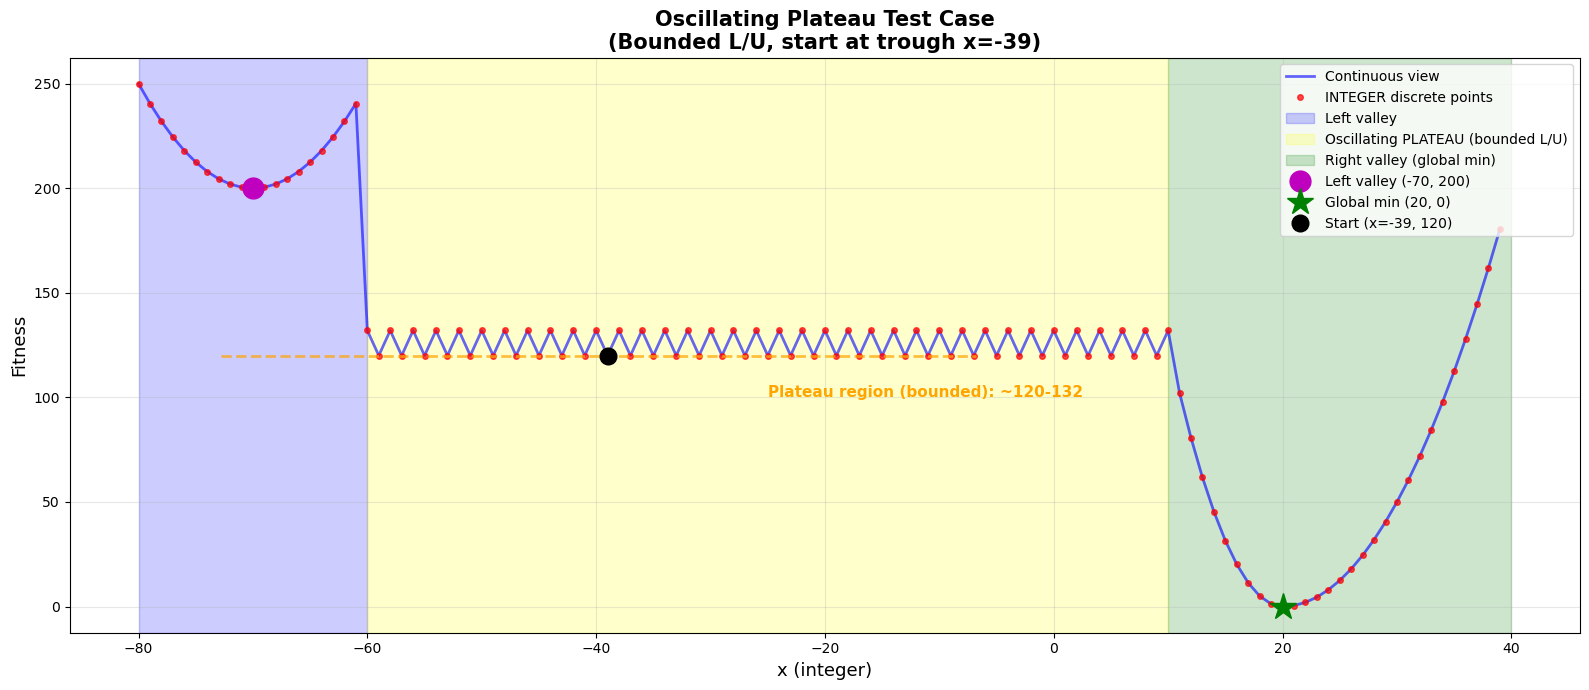


✅ Challenge: Can the algorithm compress the entire 71-point plateau
   with 35 local minima in ONE compression?

🚀 TEST: Oscillating Plateau Compression (bounded)

Starting at x=-39, fitness=120.00
Expected: One-shot compression from trough to the first descent beyond PR.

Starting at x=-39, fitness=120.00

--- Iteration 1 ---
⚠️  STUCK at local min: x=-39, fitness=120
   Detecting basin (bi-directional, with bridge margin)...
  Detecting basin from local min: x=-39, fitness=120.00
  ✅ Basin exit at x=11, fitness=102.06 < 120.00
  ✅ Compression region: X[-39, 11], length=50

  Applying compression with metadata: [(-39, 50)]

📦 METADATA (Original X-space): [(-39, 50)]
  Compression #1:
    Original X[-39, 11] → Z[-39, 11]
    Saves 49 nodes
✅ Built 1 compressions

  ✅ Compression applied! Continue in Z-space...


--- Iteration 2 ---
⚠️  STUCK at local min: x=20, fitness=0
   Detecting basin (bi-directional, with bridge margin)...
  Detecting basin from local min: x=20, fitness=0.00
  ⚠

/tmp/ipykernel_1190579/3670883154.py:193: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


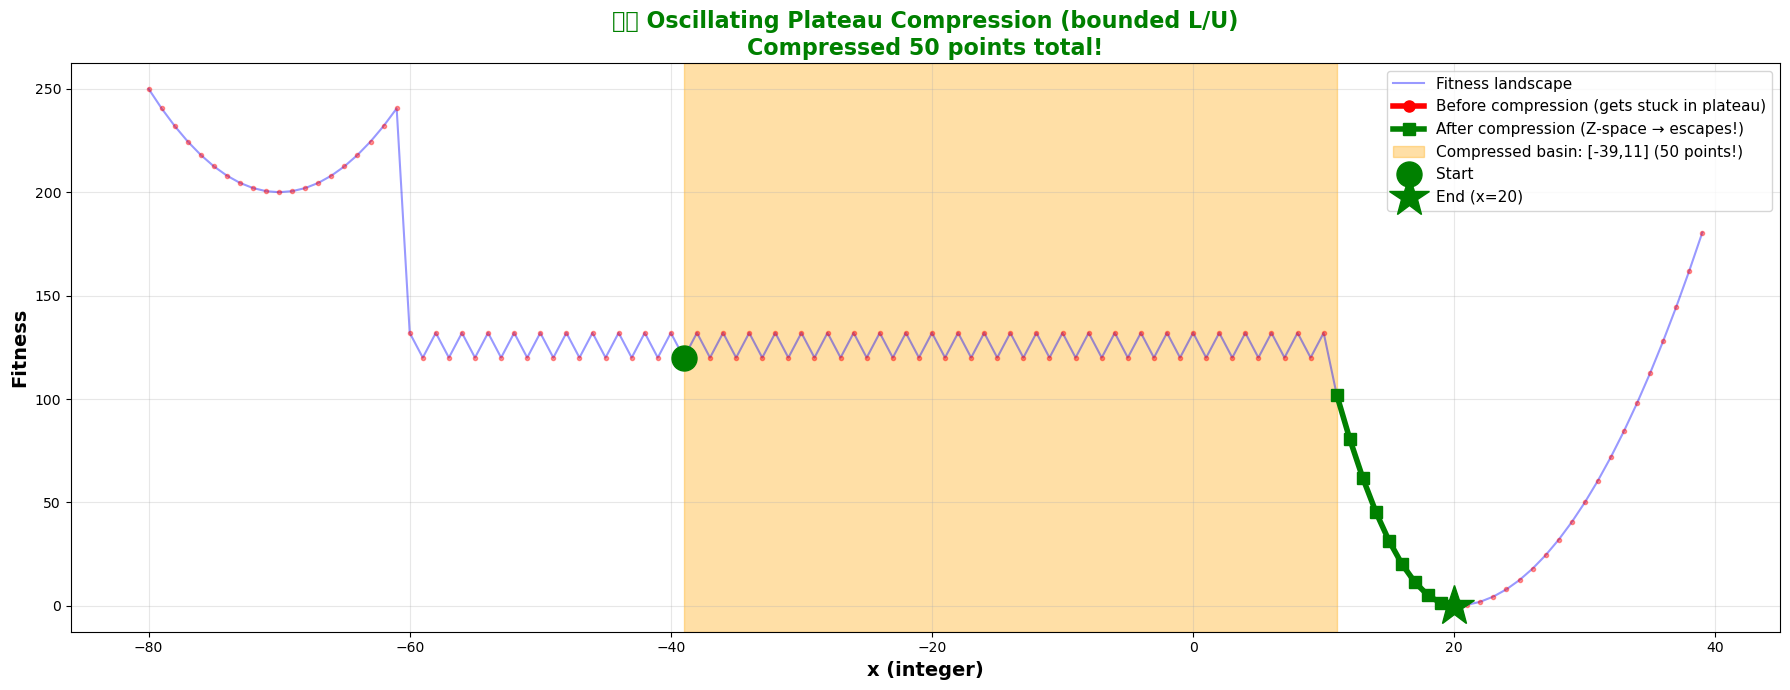


🎯 PLATEAU COMPRESSION SUCCESS:
  Basin #1: Compressed 50 points (X[-39, 11])
           Efficiency: 98.0% reduction (50 → 1)


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1) Bounded oscillating plateau
# -------------------------------
def fitness_oscillating_plateau_bounded(
    x,
    L=120.0, U=132.0,                 # 평탄부 하한/상한 (고정)
    plateau_left=-60, plateau_right=10,
    left_valley_center=-70, right_valley_center=20,
    trough_anchor=-39,                # 하한(L)이 정확히 나오게 할 기준 x (정수)
    alt_period=2                      # 교번 주기: 2면 L,U,L,U,...
):
    """
    - x < plateau_left      : 좌측 완만한 포물선(깊은 계곡)
    - plateau_left..right   : 정수 격자에서 정확히 L/U만 교번 (요철의 하/상한 고정)
                              (x - trough_anchor) % alt_period == 0 -> L, else U
    - plateau_right < x < rv: 전이 구간(우측 계곡으로 매끄럽게 하강; L보다 확실히 낮아짐)
    - x >= right_valley     : 우측 포물선(전역 최소)
    """
    x = int(x)

    if x < plateau_left:
        return 200.0 + 0.5 * (x - left_valley_center) ** 2

    if plateau_left <= x <= plateau_right:
        return L if ((x - trough_anchor) % alt_period) == 0 else U

    if plateau_right < x < right_valley_center:
        mid = 0.5 * (L + U)
        t = (x - plateau_right) / float(right_valley_center - plateau_right)  # 0→1
        return (mid * (1 - t) ** 2)  # 점점 내려가 L보다 확실히 낮아짐

    if x >= right_valley_center:
        return 0.5 * (x - right_valley_center) ** 2

    return 1e9  # safety

# 별칭
f = fitness_oscillating_plateau_bounded

# 파라미터(시각화/통계에 사용)
PL, PR = -60, 10
RV = 20
L, U = 120.0, 132.0
START_X = -39  # 하한(L)이 나오는 바닥점

# -------------------------------
# 2) Key points + plateau stats
# -------------------------------
print("=" * 80)
print("🎨 FITNESS FUNCTION: Oscillating Plateau (bounded L/U)")
print("=" * 80)
print("\nKey points:")
print(f"  x=-70 (left valley): {f(-70):.2f}")
print(f"  x={PL} (plateau start): {f(PL):.2f}")
print(f"  x=-30 (middle of plateau): {f(-30):.2f}")
print(f"  x=0 (plateau middle): {f(0):.2f}")
print(f"  x={PR} (plateau end): {f(PR):.2f}")
print(f"  x={RV} (right valley, GLOBAL MIN): {f(RV):.2f}")

plateau_region = range(PL, PR + 1)
plateau_fitness = [f(x) for x in plateau_region]
local_minima_count = sum(
    1
    for i in range(1, len(plateau_fitness) - 1)
    if plateau_fitness[i] < plateau_fitness[i - 1]
    and plateau_fitness[i] < plateau_fitness[i + 1]
)
print(f"\n📊 Plateau statistics:")
print(f"  Length: {len(plateau_region)} points")
print(f"  Local minima in plateau: {local_minima_count}")
print(f"  Min fitness in plateau: {min(plateau_fitness):.2f}")
print(f"  Max fitness in plateau: {max(plateau_fitness):.2f}")

# -------------------------------
# 3) Visualize landscape
# -------------------------------
x_viz = np.arange(-80, 40, 1)
y_viz = [f(x) for x in x_viz]

plt.figure(figsize=(16, 7))
plt.plot(x_viz, y_viz, 'b-', linewidth=2, alpha=0.6, label='Continuous view')
plt.plot(x_viz, y_viz, 'ro', markersize=4, label='INTEGER discrete points', alpha=0.7)

# Mark regions
plt.axvspan(-80, PL, alpha=0.2, color='blue', label='Left valley')
plt.axvspan(PL, PR, alpha=0.2, color='yellow', label='Oscillating PLATEAU (bounded L/U)')
plt.axvspan(PR, 40, alpha=0.2, color='green', label='Right valley (global min)')

# Key markers
plt.plot(-70, f(-70), 'mo', markersize=15, label=f'Left valley (-70, {f(-70):.0f})', zorder=10)
plt.plot(RV, f(RV), 'g*', markersize=20, label=f'Global min ({RV}, {f(RV):.0f})', zorder=10)
plt.plot(START_X, f(START_X), 'ko', markersize=12, label=f'Start (x={START_X}, {f(START_X):.0f})', zorder=10)

# Plateau bounds line
plt.axhline(y=min(plateau_fitness), xmin=0.1, xmax=0.6,
            color='orange', linestyle='--', linewidth=2, alpha=0.7)
plt.text(-25, min(plateau_fitness) - 20,
         f'Plateau region (bounded): ~{min(plateau_fitness):.0f}-{max(plateau_fitness):.0f}',
         fontsize=11, color='orange', fontweight='bold')

plt.xlabel('x (integer)', fontsize=13)
plt.ylabel('Fitness', fontsize=13)
plt.title('Oscillating Plateau Test Case\n(Bounded L/U, start at trough x=-39)', fontsize=15, fontweight='bold')
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Challenge: Can the algorithm compress the entire {len(plateau_region)}-point plateau")
print(f"   with {local_minima_count} local minima in ONE compression?")
print("=" * 80)

# -------------------------------
# 4) Run hill-climb + compression
# -------------------------------
print("\n" + "=" * 80)
print("🚀 TEST: Oscillating Plateau Compression (bounded)")
print("=" * 80)

print(f"\nStarting at x={START_X}, fitness={f(START_X):.2f}")
print("Expected: One-shot compression from trough to the first descent beyond PR.\n")

# hill_climb_with_basin_compression 이 존재하지 않을 경우를 대비해 안전 처리
try:
    trajectory_plateau, compressions_plateau = hill_climb_with_basin_compression(
        f, START_X, max_iterations=10
    )

    print(f"\n{'='*80}")
    print("📊 FINAL RESULTS:")
    print(f"{'='*80}")
    print(f"  Started at: x={trajectory_plateau[0][0]}, fitness={trajectory_plateau[0][1]:.2f}")
    print(f"  Ended at:   x={trajectory_plateau[-1][0]}, fitness={trajectory_plateau[-1][1]:.2f}")
    print(f"  Total steps: {len(trajectory_plateau)}")
    print(f"  Compressions applied: {len(compressions_plateau)}")

    if compressions_plateau:
        print(f"\n✅ Compressed basins (in ORIGINAL X-space):")
        for i, (start, length) in enumerate(compressions_plateau, 1):
            print(f"    #{i}: X[{start}, {start+length}] (length={length} points)")
            if length > 50:
                print(f"        ⭐ LARGE basin - compressed {length} points to length-1 interval!")

    if abs(trajectory_plateau[-1][1]) < 1.0:
        print(f"\n✅✅ SUCCESS! Reached global minimum at x={trajectory_plateau[-1][0]}")
    else:
        print(f"\n⚠️  Ended at fitness={trajectory_plateau[-1][1]:.2f}")

    # -------------------------------
    # 5) Visualize compression path
    # -------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    ax.plot(x_viz, y_viz, 'b-', linewidth=1.5, alpha=0.4, label='Fitness landscape')
    ax.plot(x_viz, y_viz, 'ro', markersize=3, alpha=0.4)

    traj_x = [x for x, _, _ in trajectory_plateau]
    traj_y = [val for _, val, _ in trajectory_plateau]
    traj_comp = [c for _, _, c in trajectory_plateau]

    before_idx = [i for i, c in enumerate(traj_comp) if not c]
    if before_idx:
        ax.plot([traj_x[i] for i in before_idx], [traj_y[i] for i in before_idx],
                'r-', linewidth=4, marker='o', markersize=8,
                label='Before compression (gets stuck in plateau)', zorder=5)

    after_idx = [i for i, c in enumerate(traj_comp) if c]
    if after_idx:
        ax.plot([traj_x[i] for i in after_idx], [traj_y[i] for i in after_idx],
                'g-', linewidth=4, marker='s', markersize=8,
                label='After compression (Z-space → escapes!)', zorder=5)

    if compressions_plateau:
        for i, (comp_start, comp_len) in enumerate(compressions_plateau):
            comp_end = comp_start + comp_len
            color = 'yellow' if comp_len > 50 else 'orange'
            ax.axvspan(comp_start, comp_end, alpha=0.35, color=color,
                       label=f'Compressed basin: [{comp_start},{comp_end}] ({comp_len} points!)',
                       zorder=1)

    ax.plot(traj_x[0], traj_y[0], 'go', markersize=18, label='Start', zorder=10)
    ax.plot(traj_x[-1], traj_y[-1], 'g*', markersize=30, label=f'End (x={traj_x[-1]})', zorder=10)

    ax.set_xlabel('x (integer)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Fitness', fontsize=14, fontweight='bold')
    ax.set_title(f'✅✅ Oscillating Plateau Compression (bounded L/U)\n'
                 f'Compressed {sum(c[1] for c in compressions_plateau)} points total!',
                 fontsize=16, fontweight='bold', color='green')
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n🎯 PLATEAU COMPRESSION SUCCESS:")
    if compressions_plateau:
        for i, (start, length) in enumerate(compressions_plateau, 1):
            print(f"  Basin #{i}: Compressed {length} points (X[{start}, {start+length}])")
            eff = (length - 1) / length * 100
            print(f"           Efficiency: {eff:.1f}% reduction ({length} → 1)")

except NameError:
    print("\n⚠️  hill_climb_with_basin_compression 함수가 현재 환경에 없습니다.")
    print("    - 위 함수가 준비되면 동일 코드로 바로 실행 가능합니다.")
